In [5]:
import numpy as np
import pandas as pd
import cv2
import keras
from numpy import random
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns



import os

* **Directory of dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Directory of train, validation and test

train_folder = "/content/drive/MyDrive/Disease_Prediction/CT_Scan_Data/train"
valid_folder = "/content/drive/MyDrive/Disease_Prediction/CT_Scan_Data/valid"
test_folder = "/content/drive/MyDrive/Disease_Prediction/CT_Scan_Data/test"


* **Class Labels and Size**

In [7]:
print("\n\n\t\tTraining Set")
print("\t  ========================\n")
train_c = []

for folder in os.listdir(train_folder):
    train_c.append(folder)
    print("\nTrain "+ folder + " Class: ", len(os.listdir(train_folder + '/' + folder)))

print("\n\n", train_c)

print("\n\n\t\tTesting Set")
print("\t  ========================\n")
test_c = []
for folder in os.listdir(test_folder):
    test_c.append(folder)
    print("\nTest "+ folder + " Class: ", len(os.listdir(test_folder + '/' + folder)))

print("\n\n", test_c)

print("\n\n\t\tValidation Set")
print("\t  ========================\n")
val_c = []
for folder in os.listdir(valid_folder):
    val_c.append(folder)
    print("\nValidation "+ folder + " Class: ", len(os.listdir(valid_folder + '/' + folder)))

print("\n\n", val_c, "\n")



		Training Set


Train squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  156

Train normal Class:  149

Train adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  196

Train large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  116


 ['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa']


		Testing Set


Test normal Class:  54

Test squamous.cell.carcinoma Class:  90

Test adenocarcinoma Class:  120

Test large.cell.carcinoma Class:  51


 ['normal', 'squamous.cell.carcinoma', 'adenocarcinoma', 'large.cell.carcinoma']


		Validation Set


Validation squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  15

Validation adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  23

Validation normal Class:  13

Validation large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  21


 ['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'norm

* **Define function to get Data**

In [8]:
input_shape = (224,224,3)
num_class = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 685 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


*  **VGG16**

In [ ]:

modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelVGG16.layers:
    layer.trainable = False

In [ ]:
model = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])


print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

**CallBacks**
* Checkpoint
* Early Stopping
* Reducing LR on Plateau

In [ ]:
#Defining a Checkpoint
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Disease_Prediction/Cnn_ctscan_model.h5',
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True,
                            verbose = 1)

#Defining a Early Stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                         min_delta = .5,
                         patience = 5,
                         restore_best_weights = True)

#Defining LR Reducing rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 3,
                             verbose = 1,
                             min_delta = 0.8)

#Putting the call backs in a callback list
callbacks = [earlystop, reduce_lr]

* **Training the model**

In [ ]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint]
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 2.1354 - accuracy: 0.4117 
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to /content/drive/MyDrive/Hack-O-Med/Cnn_ctscan_model.h5
22/22 [==============================] - 414s 18s/step - loss: 2.1354 - accuracy: 0.4117 - val_loss: 1.2225 - val_accuracy: 0.5556
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 1.3044 - accuracy: 0.5372
Epoch 2: val_accuracy did not improve from 0.55556
22/22 [==============================] - 14s 647ms/step - loss: 1.3044 - accuracy: 0.5372 - val_loss: 0.9394 - val_accuracy: 0.5417
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.0705 - accuracy: 0.5635
Epoch 3: val_accuracy improved from 0.55556 to 0.58333, saving model to /content/drive/MyDrive/Hack-O-Med/Cnn_ctscan_model.h5
22/22 [==============================] - 16s 730ms/step - loss: 1.0705 - accuracy: 0.5635 - val_loss: 0.8677 - val_accuracy: 0.5833
Epoch 4/50
22/22 [====

* **Classification Report**

In [ ]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)


10/10 [==============================] - 3s 243ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       120
           1       0.88      0.98      0.93        51
           2       1.00      0.98      0.99        54
           3       0.94      0.87      0.90        90

    accuracy                           0.93       315
   macro avg       0.93      0.94      0.93       315
weighted avg       0.93      0.93      0.93       315



* **Confussion Matrix**



Confusion Matrix:
 [[111   4   0   5]
 [  1  50   0   0]
 [  0   1  53   0]
 [ 10   2   0  78]]


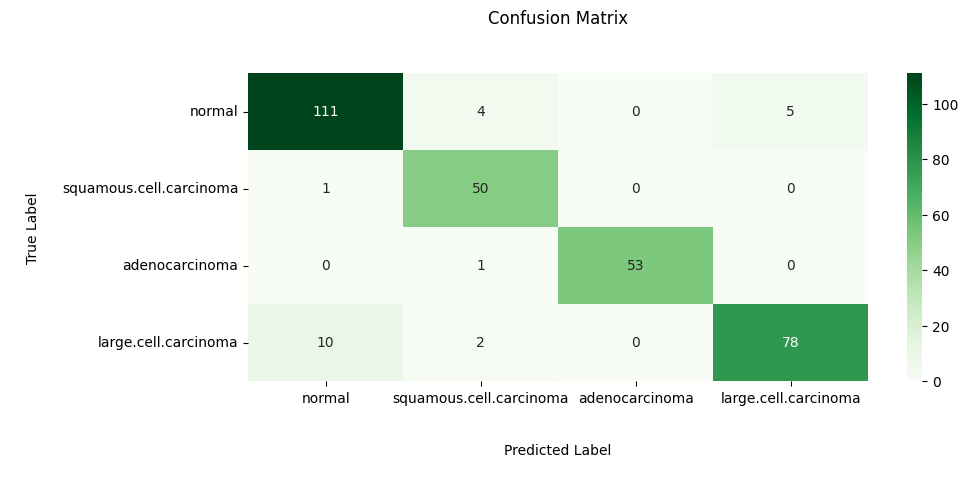

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

* **Loss Charts**

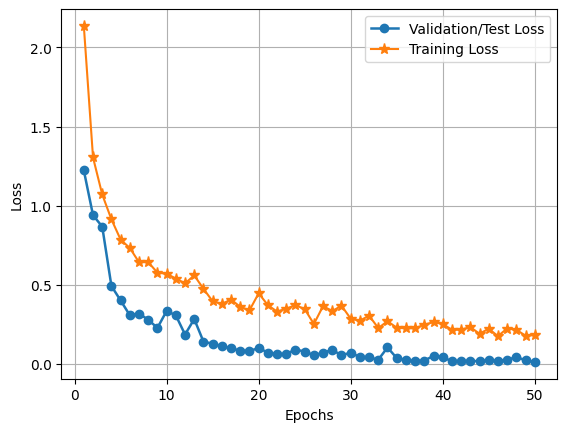

In [ ]:
#Plotting the loss charts

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

* **Accuracy Charts**

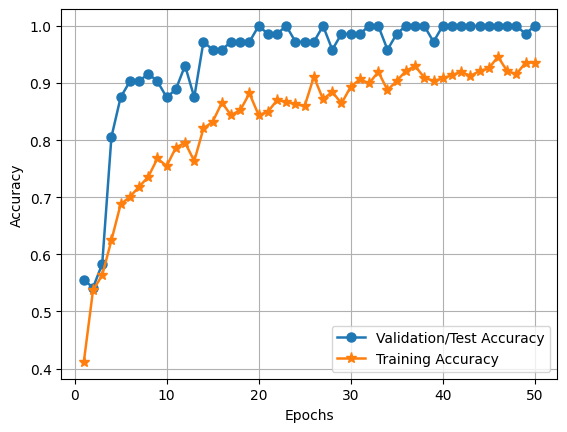

In [ ]:
#Plotting the accuracy charts

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# import numpy as np

class_names = list(train_generator.class_indices.keys())
class_names

# for image_batch, label_batch in test_generator:
#     first_image = image_batch[0]
#     first_label = label_batch[0][0]  # Extract the first label from the batch

#     # Convert the label to integer
#     first_label = int(first_label)

#     print("First image to predict")
#     plt.imshow(first_image)
#     plt.axis('off')
#     print("actual label:",class_names[first_label])


#     batch_prediction = model.predict(image_batch)'/content/drive/MyDrive/Hack-O-Med/Cnn_ctscan_model.h5'
#     print("predicted label:",class_names[np.argmax(batch_prediction[0])])
#     plt.show()
#     break

# Now you can use the "model" variable to make predictions on new images.
# For example, if you have a new image stored in the variable "new_image", you can make predictions as follows:
# predictions = model.predict(new_image)


['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model


model = load_model('/content/drive/MyDrive/Disease_Prediction/Cnn_ctscan_model.h5')

In [13]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


<ipython-input-14-11c084a83987>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i + 1)


1/1 [==============================] - 0s 18ms/step


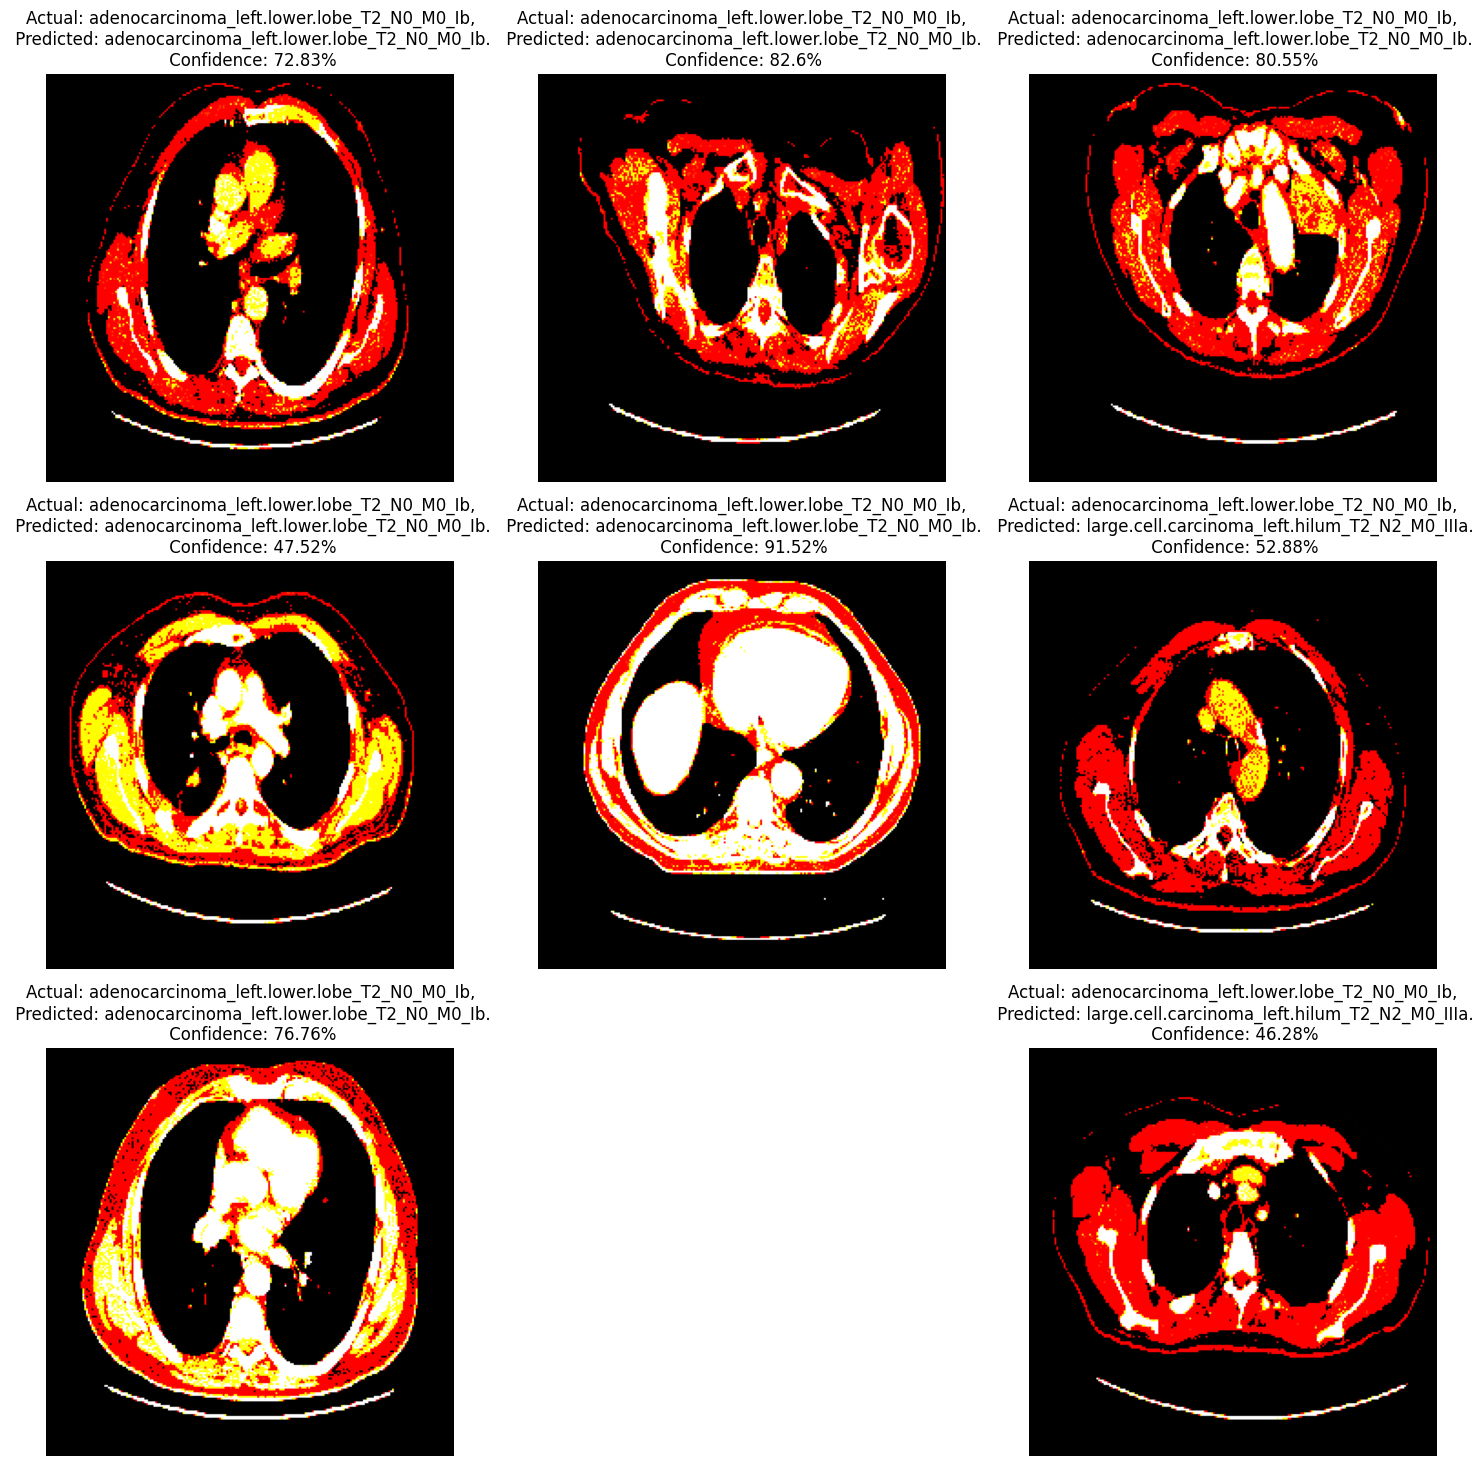

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access the index with np.argmax()

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.tight_layout()
        plt.axis("off")
    break

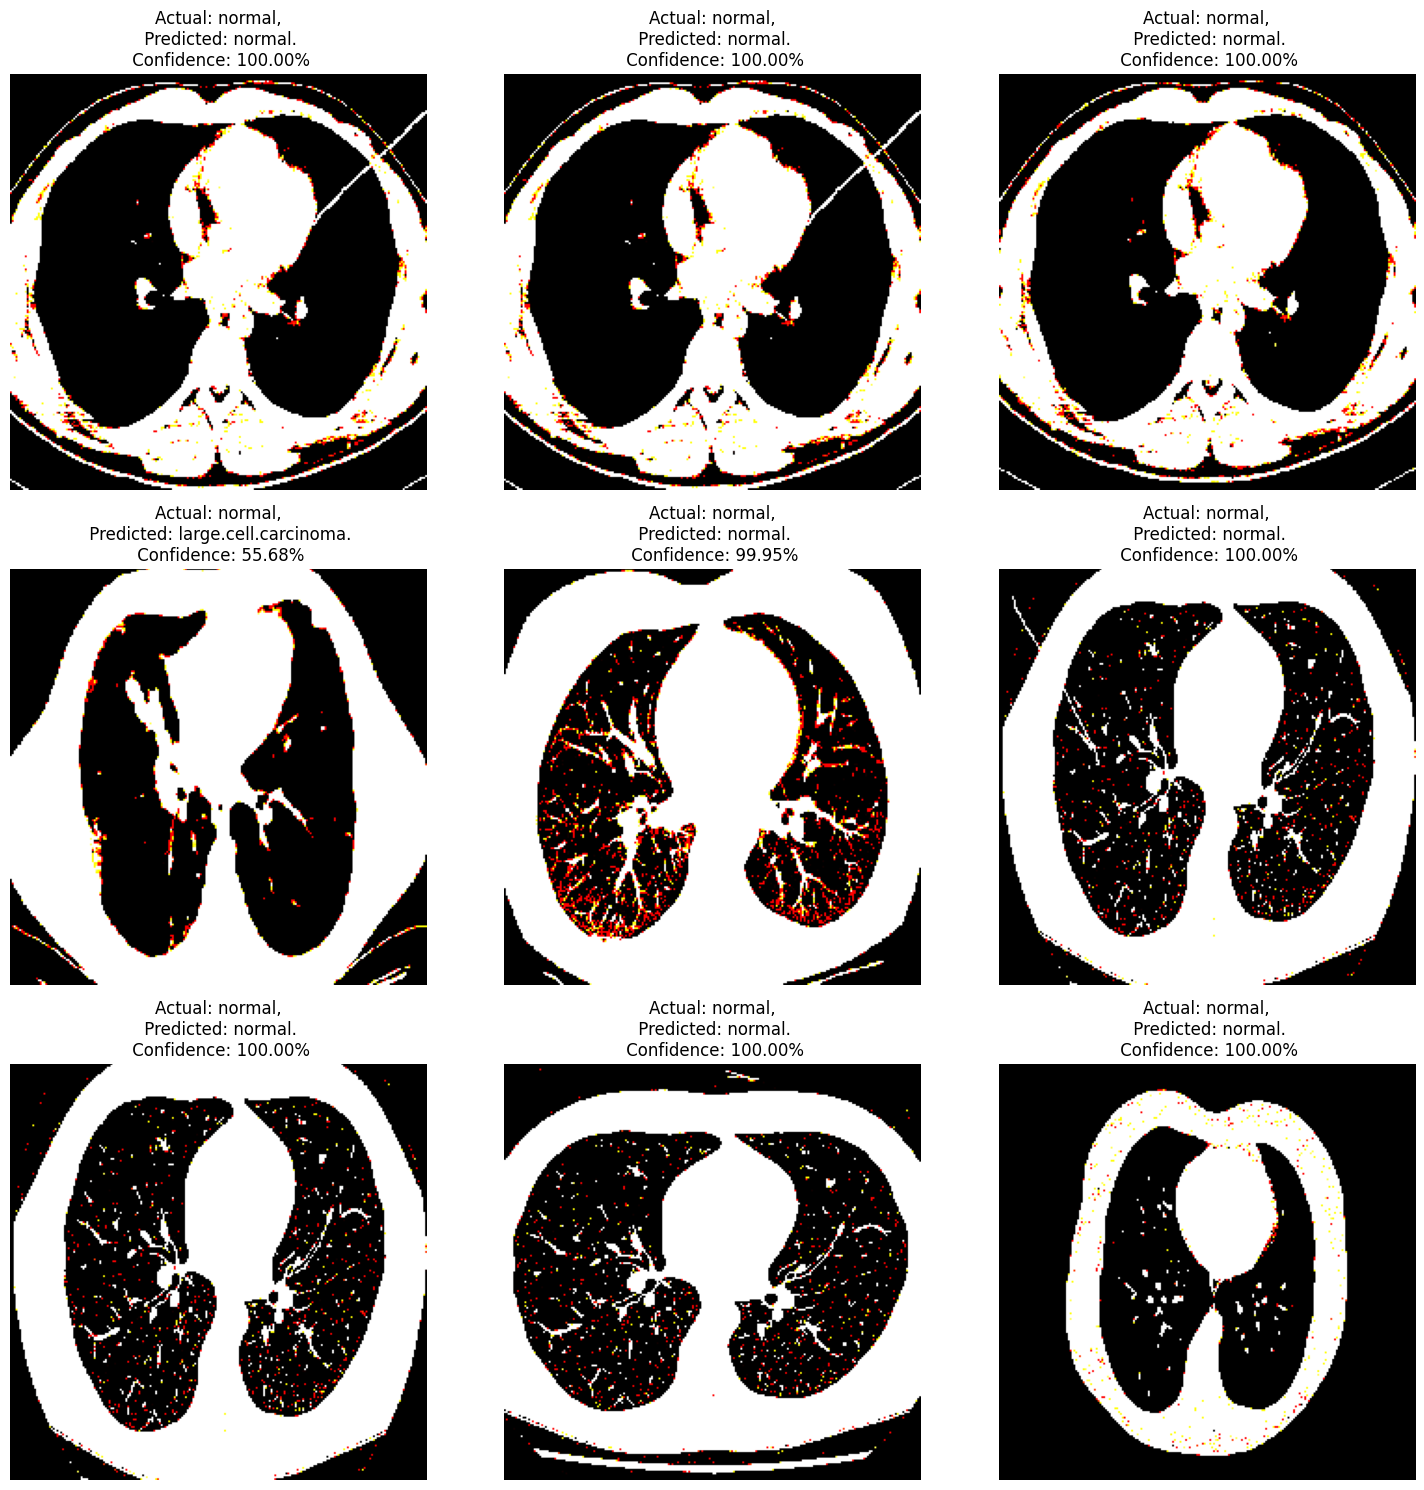

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define your prediction function
def predict(interpreter, image):
    input_data = np.expand_dims(image, axis=0)  # Expand dimensions to match model input
    input_data = input_data.astype(np.float32)   # Convert to float32

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = class_names[np.argmax(output_data)]
    confidence = np.max(output_data) * 100

    return predicted_class, confidence

# Load your TFLite model
model_path = "/content/drive/MyDrive/Disease_Prediction/model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define your class names
class_names = ["adenocarcinoma", "large.cell.carcinoma", "normal", "squamous.cell.carcinoma"]

# Plot predictions
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(interpreter, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access the index with np.argmax()

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")

        plt.axis("off")
    break

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

# Load the pre-trained model
model_path = '/content/drive/MyDrive/Disease_Prediction/Cnn_ctscan_model.h5'
model = tf.keras.models.load_model(model_path)
tf.__version__

'2.12.0'